# Vortex-panel Method for Lifting Bodies

# Part 1: Williams' test case

In [1]:
import math
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline

In [2]:
x_main, y_main = numpy.loadtxt('../AeroPython/lessons/resources/MainFoil_N=100.csv', dtype=float, delimiter=',', unpack=True)
x_flap, y_flap = numpy.loadtxt('../AeroPython/lessons/resources/FlapFoil_N=100.csv', dtype=float, delimiter=',', unpack=True)

In [3]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'extrados'
        else:
            self.loc = 'intrados'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [4]:
def define_panels(x, y, N):
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])    # extend arrays using numpy.append
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [5]:
Np=len(x_main)-1

panels_main = define_panels(x_main, y_main, Np)   # discretizes of the airfoil into panels

panels_flap = define_panels(x_flap, y_flap, Np)   # discretizes of the flap into panels

#print numpy.shape(panels_airfoil)

In [6]:
Np

100

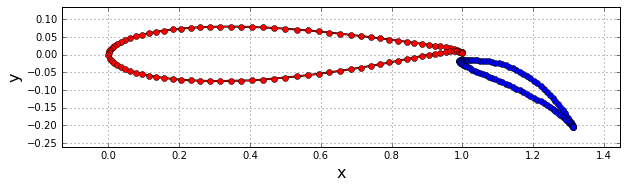

In [7]:
# plots the geometry and the panels
val_x, val_y = 0.1, 0.2
x_min, x_max = min( panel.xa for panel in panels_main ), max( panel.xa for panel in panels_flap )
y_min, y_max = min( panel.ya for panel in panels_flap ), max( panel.ya for panel in panels_main )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels_main], panels_main[0].xa), 
         numpy.append([panel.ya for panel in panels_main], panels_main[0].ya), 
         linestyle='-', linewidth=1, marker='o', markersize=6, color='r');

pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels_flap], panels_flap[0].xa), 
         numpy.append([panel.ya for panel in panels_flap], panels_flap[0].ya), 
         linestyle='-', linewidth=1, marker='o', markersize=6, color='b');

In [8]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.U_inf = U_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians

In [9]:
U_inf = 1.0                                # freestream spee
alpha = 0.0                                # angle of attack (in degrees)
freestream = Freestream(U_inf, alpha)      # instantiation of the object freestream

In [10]:
def integral(x, y, panel, dxdz, dydz):
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
N = 2*Np #Redifining N, so when we do slices in N we are talking about N=N_airfoil+N_flap
panels = numpy.concatenate((panels_main, panels_flap))

In [12]:
Np

100

In [13]:
N

200

In [14]:
def source_matrix_normal(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels: array of panels.
    
    Returns
    -------
    A_n: NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A_n = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A_n, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A_n[i,j] = 0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.cos(p_i.beta), numpy.sin(p_i.beta))
                
    return A_n

In [15]:
def vortex_matrix_normal(panels):
    """Builds the vortex matrix.
    
    Arguments
    ---------
    panels: array of panels.
    
    Returns
    -------
    B_n: NxN matrix (N is the number of panels).
    s_bn: 1D array (Nx1, N is the number of panels) 
         (is the sum over j of the coefficients ).
    """
    N = len(panels)
    B_n = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(B_n, 0.)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                B_n[i,j] = -0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
                
    return B_n

In [16]:
def vortex_arrays_normal(panels, B_n):
    """Builds the vortex array for normal matrix.
    
    Arguments
    ---------
    panels: array of panels.
    B_n: NxN matrix (N is the number of panels). Vortex normal matrix
    Returns
    -------
    a -- 1D array (Nx1, N is the number of panels).
    """
    N = len(panels)
    a1_n = numpy.zeros(panels.size, dtype=float)
    a2_n = numpy.zeros(panels.size, dtype=float)
    for i, p_i in enumerate(panels):
        
            a1_n[i] = numpy.sum(B_n[i,0:N/2]) 
            a2_n[i] = numpy.sum(B_n[i,N/2:])
    
    return a1_n , a2_n

In [17]:
 #Redifining N, so when we do slices in N we are talking about N=N_airfoil+N_flap
panels = numpy.concatenate((panels_main, panels_flap))
A_n = source_matrix_normal(panels)
B_n = vortex_matrix_normal(panels)
a1_n , a2_n = vortex_arrays_normal(panels, B_n)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [18]:
def A_normal(A_n, a1_n , a2_n, N):
    """Builds the normal matrix.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: NxN matrix (N is the number of panels). Vortex normal matrix
    a1_n -- 1D array (Nx1, N is the number of panels).
    a2_n -- 1D array (Nx1, N is the number of panels).
    Returns
    -------
    A_normal: Nx(N+2) matrix (N is the number of panels).
    """

    #Matrix A_normal (Nx(N+2))

    A_normal = numpy.empty((N, N+2), dtype=float)

    A_normal[0:N,0:N] = A_n[:,:]
    A_normal[0:N,-2] = a1_n[:]
    A_normal[0:N,-1] = a2_n[:]
    
    return A_normal

In [19]:
A_normal = A_normal(A_n, a1_n , a2_n, N)

In [20]:
def vortex_arrays_tangential(panels, A_n):
    """Builds the vortex array for normal matrix.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: NxN matrix (N is the number of panels). Source normal matrix
    Returns
    -------
    a1_t -- 1D array (Nx1, N is the number of panels).
    a2_t -- 1D array (Nx1, N is the number of panels).
    """
    N = len(panels)
    a1_t = numpy.zeros(panels.size, dtype=float)
    a2_t = numpy.zeros(panels.size, dtype=float)
    for i, p_i in enumerate(panels):
        
            a1_t[i] = numpy.sum(A_n[i,0:N/2]) 
            a2_t[i] = numpy.sum(A_n[i,N/2:])
    
    return a1_t , a2_t

In [21]:
a1_t , a2_t = vortex_arrays_tangential(panels, A_n)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [22]:
def A_tangential(B_n, a1_t , a2_t, N):
    """Builds the tangential matrix.
    
    Arguments
    ---------
    panels: array of panels.
    B_n: NxN matrix (N is the number of panels). Vortex normal matrix
    
    Returns
    -------
    A_tangential: Nx(N+2) matrix (N is the number of panels).
    """

    #Matrix A_tangential (Nx(N+2))

    A_tangential = numpy.empty((N, N+2), dtype=float)

    A_tangential[0:N,0:N] = B_n[:,:]
    A_tangential[0:N,-2] = -a1_t[:]
    A_tangential[0:N,-1] = -a2_t[:]
    
    return A_tangential

In [23]:
A_tangential = A_tangential(B_n, a1_t , a2_t, N)

In [24]:
#Kutta arrays

def kutta_arrays(A_tangential, N):
    """Builds the kutta arrays.
    
    Arguments
    ---------
    A_tangential: Nx(N+2) matrix (N is the number of panels).
    
    Returns
    -------
    k_a1 -- 1D array ((N+2)x1, N is the number of panels). kutta array 1
    k_a2 -- 1D array ((N+2)x1, N is the number of panels). kutta array 2
    """
    k_a1 = numpy.zeros(N+2,dtype=float)
    k_a2 = numpy.zeros(N+2,dtype=float)

    k_a1 = A_tangential[0,:] + A_tangential[N/2-1,:]
    k_a2 = A_tangential[N/2,:] + A_tangential[N-1,:]
    
    return k_a1, k_a2

In [25]:
k_a1, k_a2 = kutta_arrays(A_tangential, N)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [26]:
#The A matrix for the linear system

def build_matrix(panels, A_normal, k_a1, k_a2):
    """Builds the matrix of the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: matrix normal
    k_a1: Kutta array 1
    k_a2: Kutta array 2
    
    Returns
    -------
    A -- (N+2)x(N+2) matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N+2, N+2), dtype=float)
    
    A[0:N,:] = A_normal[:,:]
    A[-2,:] = k_a1[:]
    A[-1,:] = k_a2[:]
    
    return A

In [27]:
def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    freestream: farfield conditions.
    
    Returns
    -------
    b: 1D array ((N+2)x1, N is the number of panels).
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.U_inf * numpy.cos(freestream.alpha - panel.beta)
    b[N] = -freestream.U_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                              +numpy.sin(freestream.alpha-panels[N/2-1].beta) )
    b[N+1] = -freestream.U_inf*( numpy.sin(freestream.alpha-panels[N/2].beta)
                              +numpy.sin(freestream.alpha-panels[N-1].beta) )
    return b

In [28]:
A = build_matrix(panels, A_normal, k_a1, k_a2)                 # calculates the singularity matrix
b = build_rhs(panels, freestream)         # calculates the freestream RHS

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [29]:
# solves the linear system
variables = linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = variables[i]
gamma1 = variables[-2]
gamma2 = variables[-1]

In [30]:
def get_tangential_velocity(panels, freestream, gamma1, gamma2, A_tangential):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma1 -- circulation density of airfoil.
    gamma2 -- circulation density of flap.
    
    """
    N = len(panels)

    b = freestream.U_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    var1 = numpy.append([panel.sigma for panel in panels], gamma1)
    var = numpy.append(var1, gamma2)
    
    vt = numpy.dot(A_tangential, var) + b
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [31]:
get_tangential_velocity(panels, freestream, gamma1, gamma2, A_tangential)

In [32]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.U_inf)**2

In [33]:
get_pressure_coefficient(panels, freestream)

In [34]:
x_main_t, cp_main_t = numpy.loadtxt('../AeroPython/lessons/resources/Cp_Main_theoretical.csv', delimiter=',', unpack=True)
x_flap_t, cp_flap_t = numpy.loadtxt('../AeroPython/lessons/resources/Cp_Flap_theoretical.csv', delimiter=',', unpack=True)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


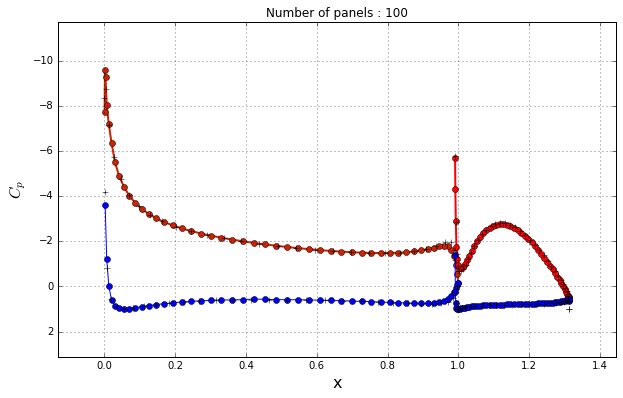

In [35]:
val_x, val_y = 0.1, 0.2
x_min, x_max = min( panel.xa for panel in panels ), max( panel.xa for panel in panels )
cp_min, cp_max = min( panel.cp for panel in panels ), max( panel.cp for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

# plots the surface pressure coefficient
N = len(panels)
airfoil = panels[:N/2]
flap = panels[N/2:]

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in airfoil if panel.loc == 'extrados'], 
         [panel.cp for panel in airfoil if panel.loc == 'extrados'], 
         color='#CD2305', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flap if panel.loc == 'extrados'], 
         [panel.cp for panel in flap if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in airfoil if panel.loc == 'intrados'], 
         [panel.cp for panel in airfoil if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flap if panel.loc == 'intrados'], 
         [panel.cp for panel in flap if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot(x_main_t, cp_main_t, 'k+', x_flap_t, cp_flap_t, 'k+')

pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels : %d' % Np);

In [36]:
def get_coefficients(panels):
    L = 0.
    D = 0.
    for panel in panels:
        L -= panel.cp*panel.length*numpy.sin(panel.beta)
        D += panel.cp*panel.length*numpy.cos(panel.beta)
    return L, D

In [37]:
L, D = get_coefficients(panels)

Q1:What is the pressure coefficient on the 3rd panel on the main airfoil?

In [38]:
panels[2].cp

-0.95570117298077895

Q2: What is the pressure coefficient on the  10th panel on the flap airfoil?

In [39]:
panels[N/2+9].cp

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


-0.27991839836855581

Q3: What is the value of lift?

In [40]:
L

3.6977144768607482

Q4: What is the value of drag?

In [41]:
D

0.010791403245870789

Q5: Run the program again with 200 panels on both main and flap airfoils. What is the percentage of improvement of the absolute error in the value of lift

In [42]:
x_main, y_main = numpy.loadtxt('../AeroPython/lessons/resources/MainFoil_N=200.csv', dtype=float, delimiter=',', unpack=True)
x_flap, y_flap = numpy.loadtxt('../AeroPython/lessons/resources/FlapFoil_N=200.csv', dtype=float, delimiter=',', unpack=True)

In [43]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya: Cartesian coordinates of the first end-point.
        xb, yb: Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2            # control-point (center-point)
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= numpy.pi:
            self.loc = 'extrados'                   #upper face
        else:
            self.loc = 'intrados'                   #lower face
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [44]:
def define_panels(x ,y ,N):
    """Discretizes the geometry into panels using 'cosine' method.
    
    Arguments
    ---------
    x, y : Cartesian coordinates of the geometry (1d arrays).
    N: number of panels (40 by default)
    
    Returns
    -------
    panels: Numpy array of panels
    """
    
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])    # extend arrays using numpy.append
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

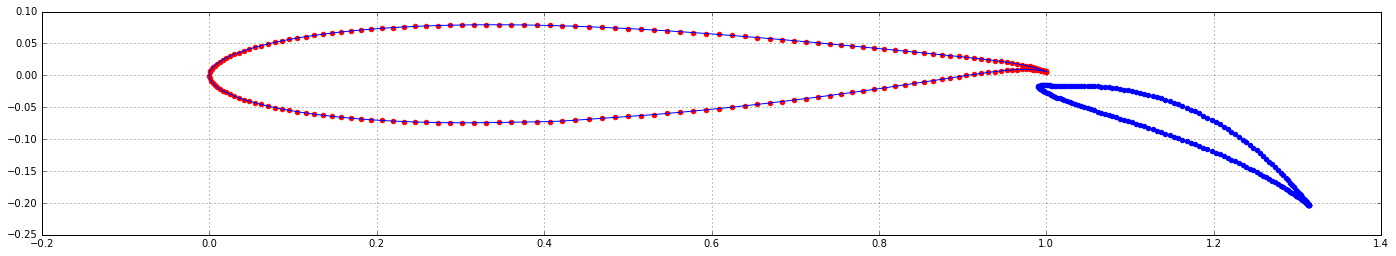

In [45]:
N = 200 #number of panels on airfoil/flap
size = 10
pyplot.figure(figsize=(24,4))
pyplot.plot(x_main, y_main, x_flap, y_flap,  color='b', linestyle='-', linewidth=1);
pyplot.grid(True)
panels_main, panels_flap = define_panels(x_main, y_main, N), define_panels(x_flap, y_flap, N)
pyplot.scatter([panel.xa for panel in panels_main], [panel.ya for panel in panels_main], color='r');
pyplot.scatter([panel.xa for panel in panels_flap], [panel.ya for panel in panels_flap], color='b');

In [46]:
Np=len(x_main)-1

panels_main = define_panels(x_main, y_main, Np)   # discretizes of the airfoil into panels

panels_flap = define_panels(x_flap, y_flap, Np)   # discretizes of the flap into panels

#print numpy.shape(panels_airfoil)

In [47]:
class Freestream:
    """Freestream conditions."""
    def __init__(self, U_inf=1.0, alpha=0.0):
        """Sets the freestream conditions.
        
        Arguments
        ---------
        U_inf: Farfield speed (default 1.0).
        alpha: Angle of attack in degrees (default 0.0).
        """
        self.U_inf = U_inf
        self.alpha = alpha*numpy.pi/180          # degrees to radians

In [48]:
# defines and creates the object freestream
U_inf = 1.0                                # freestream speed
alpha = 0.0                                # angle of attack (in degrees)
freestream = Freestream(U_inf, alpha)      # instantiation of the object freestream

In [49]:
def integral(x, y, panel, dxdk, dydk):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y: Cartesian coordinates of the point.
    panel: panel which contribution is evaluated.
    dxdk: derivative of x in the z-direction.
    dydk:  derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    def func(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., panel.length)[0]

In [50]:
N = 2*Np #Redifining N, so when we do slices in N we are talking about N=N_airfoil+N_flap
panels = numpy.concatenate((panels_main, panels_flap))

In [51]:
def source_matrix_normal(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels: array of panels.
    
    Returns
    -------
    A_n: NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A_n = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A_n, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A_n[i,j] = 0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.cos(p_i.beta), numpy.sin(p_i.beta))
                
    return A_n

In [52]:
def vortex_matrix_normal(panels):
    """Builds the vortex matrix.
    
    Arguments
    ---------
    panels: array of panels.
    
    Returns
    -------
    B_n: NxN matrix (N is the number of panels).
    s_bn: 1D array (Nx1, N is the number of panels) 
         (is the sum over j of the coefficients ).
    """
    N = len(panels)
    B_n = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(B_n, 0.)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                B_n[i,j] = -0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
                
    return B_n

In [53]:
def vortex_arrays_normal(panels, B_n):
    """Builds the vortex array for normal matrix.
    
    Arguments
    ---------
    panels: array of panels.
    B_n: NxN matrix (N is the number of panels). Vortex normal matrix
    Returns
    -------
    a -- 1D array (Nx1, N is the number of panels).
    """
    N = len(panels)
    a1_n = numpy.zeros(panels.size, dtype=float)
    a2_n = numpy.zeros(panels.size, dtype=float)
    for i, p_i in enumerate(panels):
        
            a1_n[i] = numpy.sum(B_n[i,0:N/2]) 
            a2_n[i] = numpy.sum(B_n[i,N/2:])
    
    return a1_n , a2_n


In [54]:
panels = numpy.concatenate((panels_main, panels_flap))
A_n = source_matrix_normal(panels)
B_n = vortex_matrix_normal(panels)
a1_n , a2_n = vortex_arrays_normal(panels, B_n)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [55]:
def A_normal(A_n, a1_n , a2_n, N):
    """Builds the normal matrix.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: NxN matrix (N is the number of panels). Vortex normal matrix
    a1_n -- 1D array (Nx1, N is the number of panels).
    a2_n -- 1D array (Nx1, N is the number of panels).
    Returns
    -------
    A_normal: Nx(N+2) matrix (N is the number of panels).
    """

    #Matrix A_normal (Nx(N+2))

    A_normal = numpy.empty((N, N+2), dtype=float)

    A_normal[0:N,0:N] = A_n[:,:]
    A_normal[0:N,-2] = a1_n[:]
    A_normal[0:N,-1] = a2_n[:]
    
    return A_normal

In [56]:
A_normal = A_normal(A_n, a1_n , a2_n, N)

In [57]:
def vortex_arrays_tangential(panels, A_n):
    """Builds the vortex array for normal matrix.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: NxN matrix (N is the number of panels). Source normal matrix
    Returns
    -------
    a1_t -- 1D array (Nx1, N is the number of panels).
    a2_t -- 1D array (Nx1, N is the number of panels).
    """
    N = len(panels)
    a1_t = numpy.zeros(panels.size, dtype=float)
    a2_t = numpy.zeros(panels.size, dtype=float)
    for i, p_i in enumerate(panels):
        
            a1_t[i] = numpy.sum(A_n[i,0:N/2]) 
            a2_t[i] = numpy.sum(A_n[i,N/2:])
    
    return a1_t , a2_t

In [58]:
a1_t , a2_t = vortex_arrays_tangential(panels, A_n)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [59]:
def A_tangential(B_n, a1_t , a2_t, N):
    """Builds the tangential matrix.
    
    Arguments
    ---------
    panels: array of panels.
    B_n: NxN matrix (N is the number of panels). Vortex normal matrix
    
    Returns
    -------
    A_tangential: Nx(N+2) matrix (N is the number of panels).
    """

    #Matrix A_tangential (Nx(N+2))

    A_tangential = numpy.empty((N, N+2), dtype=float)

    A_tangential[0:N,0:N] = B_n[:,:]
    A_tangential[0:N,-2] = -a1_t[:]
    A_tangential[0:N,-1] = -a2_t[:]
    
    return A_tangential

In [60]:
A_tangential = A_tangential(B_n, a1_t , a2_t, N)

In [61]:
#Kutta arrays

def kutta_arrays(A_tangential, N):
    """Builds the kutta arrays.
    
    Arguments
    ---------
    A_tangential: Nx(N+2) matrix (N is the number of panels).
    
    Returns
    -------
    k_a1 -- 1D array ((N+2)x1, N is the number of panels). kutta array 1
    k_a2 -- 1D array ((N+2)x1, N is the number of panels). kutta array 2
    """
    k_a1 = numpy.zeros(N+2,dtype=float)
    k_a2 = numpy.zeros(N+2,dtype=float)

    k_a1 = A_tangential[0,:] + A_tangential[N/2-1,:]
    k_a2 = A_tangential[N/2,:] + A_tangential[N-1,:]
    
    return k_a1, k_a2

In [62]:
k_a1, k_a2 = kutta_arrays(A_tangential, N)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [63]:
def build_matrix(panels, A_normal, k_a1, k_a2):
    """Builds the matrix of the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    A_n: matrix normal
    k_a1: Kutta array 1
    k_a2: Kutta array 2
    
    Returns
    -------
    A -- (N+2)x(N+2) matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N+2, N+2), dtype=float)
    
    A[0:N,:] = A_normal[:,:]
    A[-2,:] = k_a1[:]
    A[-1,:] = k_a2[:]
    
    return A

In [64]:
def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels: array of panels.
    freestream: farfield conditions.
    
    Returns
    -------
    b: 1D array ((N+2)x1, N is the number of panels).
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.U_inf * numpy.cos(freestream.alpha - panel.beta)
    b[N] = -freestream.U_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                              +numpy.sin(freestream.alpha-panels[N/2-1].beta) )
    b[N+1] = -freestream.U_inf*( numpy.sin(freestream.alpha-panels[N/2].beta)
                              +numpy.sin(freestream.alpha-panels[N-1].beta) )
    return b

In [65]:
A = build_matrix(panels, A_normal, k_a1, k_a2)                 # calculates the singularity matrix
b = build_rhs(panels, freestream)         # calculates the freestream RHS


/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [66]:
# solves the linear system
variables = linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = variables[i]
gamma1 = variables[-2]
gamma2 = variables[-1]

In [67]:
def get_tangential_velocity(panels, freestream, gamma1, gamma2, A_tangential):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma1 -- circulation density of airfoil.
    gamma2 -- circulation density of flap.
    
    """
    N = len(panels)

    b = freestream.U_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    var1 = numpy.append([panel.sigma for panel in panels], gamma1)
    var = numpy.append(var1, gamma2)
    
    vt = numpy.dot(A_tangential, var) + b
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [68]:
get_tangential_velocity(panels, freestream, gamma1, gamma2, A_tangential)

In [69]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.U_inf)**2

In [70]:
get_pressure_coefficient(panels, freestream)

In [71]:
x_air_t, cp_air_t = numpy.loadtxt('../AeroPython/lessons/resources/Cp_Main_theoretical.csv', delimiter=',', unpack=True)
x_flap_t, cp_flap_t = numpy.loadtxt('../AeroPython/lessons/resources/Cp_Flap_theoretical.csv', delimiter=',', unpack=True)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


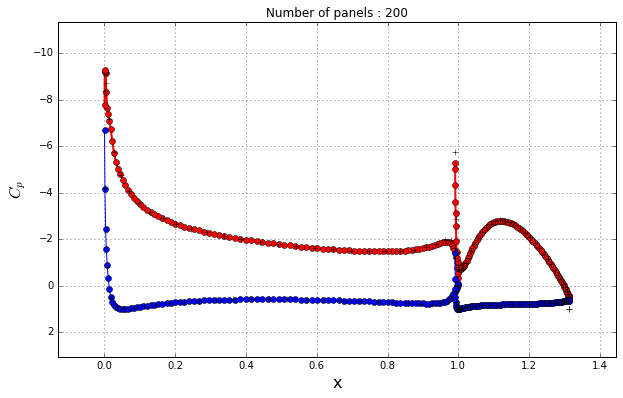

In [72]:
val_x, val_y = 0.1, 0.2
x_min, x_max = min( panel.xa for panel in panels ), max( panel.xa for panel in panels )
cp_min, cp_max = min( panel.cp for panel in panels ), max( panel.cp for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

# plots the surface pressure coefficient
N = len(panels)
airfoil = panels[:N/2]
flap = panels[N/2:]

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in airfoil if panel.loc == 'extrados'], 
         [panel.cp for panel in airfoil if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flap if panel.loc == 'extrados'], 
         [panel.cp for panel in flap if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in airfoil if panel.loc == 'intrados'], 
         [panel.cp for panel in airfoil if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flap if panel.loc == 'intrados'], 
         [panel.cp for panel in flap if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot(x_air_t, cp_air_t, 'k+', x_flap_t, cp_flap_t, 'k+')

pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels : %d' % Np);

In [73]:
def get_coefficients(panels):
    L = 0.
    D = 0.
    for panel in panels:
        L -= panel.cp*panel.length*numpy.sin(panel.beta)
        D += panel.cp*panel.length*numpy.cos(panel.beta)
    return L, D

In [74]:
L

3.6977144768607482